In [1]:
import torch
import torchaudio
import torchaudio.transforms as transforms 
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import spectrogram
from scipy.fftpack import dst, dct

songs = '/home/george-vengrovski/Documents/canary_song_detector/sample_songs'
not_songs = '/home/george-vengrovski/Documents/canary_song_detector/sample_not_songs'

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Helper Functions

In [2]:
import os
import shutil
import glob

def train_test_split(train_split=0.8):
    # Create directories if not already created
    if not os.path.exists('test'):
        os.makedirs('test')

    if not os.path.exists('train'):
        os.makedirs('train')

    # Get a list of all song files and non-song files
    songs = glob.glob('/home/george-vengrovski/Documents/canary_song_detector/sample_songs/*.wav')
    not_songs = glob.glob('/home/george-vengrovski/Documents/canary_song_detector/sample_not_songs/*.wav')

    # Split songs into train and test sets
    train_songs = songs[:int(len(songs) * train_split)]
    test_songs = songs[int(len(songs) * train_split):]

    # Copy song files into train and test directories with updated filenames
    for song in train_songs:
        file_name = os.path.basename(song)
        new_file_name = os.path.splitext(file_name)[0] + '_song.wav'
        shutil.copy(song, os.path.join('train', new_file_name))

    for song in test_songs:
        file_name = os.path.basename(song)
        new_file_name = os.path.splitext(file_name)[0] + '_song.wav'
        shutil.copy(song, os.path.join('test', new_file_name))

    # Split non-song files into train and test sets
    train_not_songs = not_songs[:int(len(not_songs) * train_split)]
    test_not_songs = not_songs[int(len(not_songs) * train_split):]

    # Copy non-song files into train and test directories with updated filenames
    for not_song in train_not_songs:
        file_name = os.path.basename(not_song)
        new_file_name = os.path.splitext(file_name)[0] + '_not_song.wav'
        shutil.copy(not_song, os.path.join('train', new_file_name))

    for not_song in test_not_songs:
        file_name = os.path.basename(not_song)
        new_file_name = os.path.splitext(file_name)[0] + '_not_song.wav'
        shutil.copy(not_song, os.path.join('test', new_file_name))
        
train_test_split()

In [3]:
from torch.nn.utils.rnn import pad_sequence

class DataSet(Dataset):
    def __init__(self, type):
        self.labels = []
        self.waveforms = [] 
        '''
        Purpose:
        - Loads song, converts to waveform, converts three different periodicties and power
        - Labels song as 1 and not song as 0 
        '''
        
        folder = 'train' if type == 'train' else 'test' 

        for file in glob.glob(folder + '/*.wav'):
            waveform, sample_rate = torchaudio.load(file)
            # Normalize the waveform
            mean = waveform.mean()
            std = waveform.std()
            waveform = (waveform - mean) / std
            self.waveforms.append(waveform)
            self.labels.append(0 if 'not_song' in file else 1)

        ## Check precentage of songs and not songs, remove some if not 50/50

    def __getitem__(self, index):
        waveform = self.waveforms[index]
        label = self.labels[index]

        label = torch.tensor(label, dtype=torch.float32)

        return waveform, label

    def __len__(self):
        return len(self.waveforms)

    def collate_fn(self, batch):
        waveforms, labels = zip(*batch)

        # Pad the waveforms
        waveforms = pad_sequence([torch.flatten(w) for w in waveforms], batch_first=True)
        
        return waveforms, labels
    

train_dataset = DataSet(type='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=train_dataset.collate_fn)

test_dataset = DataSet(type='test')
test_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=train_dataset.collate_fn)

Classifier Architecture 
- 4 1d conv layers for the waveform of the periodicities, and amplitude 
- LSTM layers afterwards 
- Fully connected layer with two nodes for song v non-song 

In [4]:
class Classifier(nn.Module):
    def __init__(self, feature_extractor_dim, hidden_size, num_layers):
        super(Classifier, self).__init__()

        # Feature extractor
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=feature_extractor_dim, kernel_size=10, padding=1, stride=5)
        self.conv2 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=3, padding=1, stride=2)
        self.conv4 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=3, padding=1, stride=2)
        self.conv5 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=3, padding=1, stride=2)
        self.conv6 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=2, padding=1, stride=2)
        self.conv7 = nn.Conv1d(in_channels=feature_extractor_dim, out_channels=feature_extractor_dim, kernel_size=2, padding=1, stride=2)

        # GRU Layer
        self.gru = nn.GRU(input_size=feature_extractor_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected layer 
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))

        # Reshape for GRU
        x = x.permute(0, 2, 1)

        # x is the output for each timestep of the GRU while h is the final hidden state
        x, h = self.gru(x)

        # x = self.fc1(F.relu(h))
        # x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(h))
        x = torch.sigmoid(x)

        x = x.squeeze(0)
        
        return x 

In [5]:
waveform, labels = next(iter(train_loader))

# # switch first and second dim
# waveform = waveform.transpose(1,2)

waveform = waveform.unsqueeze(1)

model = Classifier(feature_extractor_dim=64, hidden_size=200, num_layers=1)
print(model.forward(waveform).shape)


torch.Size([8, 1])


In [8]:
epochs = 100
learning_rate = 0.00001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(feature_extractor_dim=64, hidden_size=32, num_layers=1).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for waveform, label in train_loader:
        waveform = waveform.unsqueeze(1).to(device)
        label = torch.tensor(label).to(device)
        output = model(waveform)
        
        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss = criterion(output, label.unsqueeze(1))
        loss.backward()  # compute the gradients
        optimizer.step()

        train_loss += loss.item()

    train_accuracy = 100 * train_correct / train_total
    print ('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'.format(epoch+1, epochs, train_loss / len(train_loader), train_accuracy))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for waveform, label in test_loader:
            waveform = waveform.unsqueeze(1).to(device)
            label = torch.tensor(label).to(device)
            output = model(waveform)

            test_loss += criterion(output, label.unsqueeze(1)).item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        print('Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch+1, epochs, test_loss / len(test_loader), (correct / total) * 100))


The model has 78,177 trainable parameters
Epoch [1/100], Train Loss: 0.7136, Train Accuracy: 80.45%
Epoch [1/100], Test Loss: 0.7118, Test Accuracy: 80.45%
Epoch [2/100], Train Loss: 0.7095, Train Accuracy: 80.45%
Epoch [2/100], Test Loss: 0.7086, Test Accuracy: 80.45%
Epoch [3/100], Train Loss: 0.7071, Train Accuracy: 80.45%
Epoch [3/100], Test Loss: 0.7056, Test Accuracy: 80.45%
Epoch [4/100], Train Loss: 0.7040, Train Accuracy: 80.45%
Epoch [4/100], Test Loss: 0.7020, Test Accuracy: 80.45%
Epoch [5/100], Train Loss: 0.7007, Train Accuracy: 80.45%
Epoch [5/100], Test Loss: 0.6990, Test Accuracy: 80.45%
Epoch [6/100], Train Loss: 0.6972, Train Accuracy: 80.45%
Epoch [6/100], Test Loss: 0.6953, Test Accuracy: 80.45%
Epoch [7/100], Train Loss: 0.6934, Train Accuracy: 80.45%
Epoch [7/100], Test Loss: 0.6909, Test Accuracy: 80.45%
Epoch [8/100], Train Loss: 0.6883, Train Accuracy: 80.45%
Epoch [8/100], Test Loss: 0.6858, Test Accuracy: 80.45%
Epoch [9/100], Train Loss: 0.6844, Train Accur

KeyboardInterrupt: 

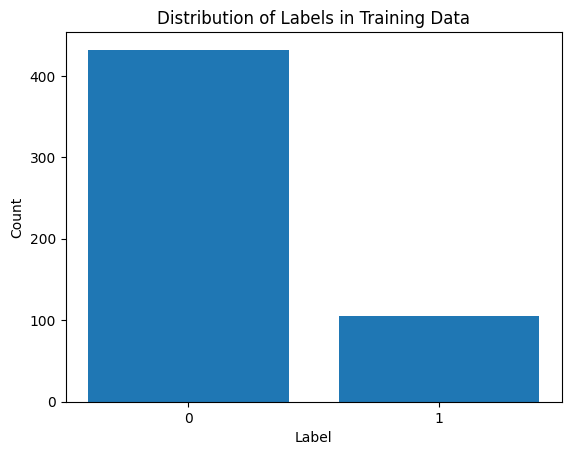

In [ ]:
label_type = []

for waveform, label in test_loader:
    label_type.append(label)

# plot label type distribution
import numpy as np
import matplotlib.pyplot as plt

# Flatten the list of labels and convert to numpy array
labels_flat = np.concatenate(label_type)

# Count the number of each label
(unique, counts) = np.unique(labels_flat, return_counts=True)

# Plot the distribution
plt.bar(unique, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Data')
plt.xticks(unique)
plt.show()
